In [139]:
from sklearn.decomposition import PCA as sklearnPCA
from scipy.signal import butter, lfilter, filtfilt
import copy
import pandas as pd
from sklearn.cluster import KMeans

# This class removes the high frequency data (that might be considered noise) from the data.
# We can only apply this when we do not have missing values (i.e. NaN).
class LowPassFilter:
    def low_pass_filter(
        self,
        data_table,
        col,
        sampling_frequency,
        cutoff_frequency,
        order=5,
        phase_shift=True,
    ):
        # http://stackoverflow.com/questions/12093594/how-to-implement-band-pass-butterworth-filter-with-scipy-signal-butter
        # Cutoff frequencies are expressed as the fraction of the Nyquist frequency, which is half the sampling frequency
        nyq = 0.5 * sampling_frequency
        cut = cutoff_frequency / nyq

        b, a = butter(order, cut, btype="low", output="ba", analog=False)
        if phase_shift:
            data_table[col + "_lowpass"] = filtfilt(b, a, data_table[col])
        else:
            data_table[col + "_lowpass"] = lfilter(b, a, data_table[col])
        return data_table


# Class for Principal Component Analysis. We can only apply this when we do not have missing values (i.e. NaN).
# For this we have to impute these first, be aware of this.
class PrincipalComponentAnalysis:

    pca = []

    def __init__(self):
        self.pca = []

    def normalize_dataset(self, data_table, columns):
        dt_norm = copy.deepcopy(data_table)
        for col in columns:
            dt_norm[col] = (data_table[col] - data_table[col].mean()) / (
                data_table[col].max()
                - data_table[col].min()
                # data_table[col].std()
            )
        return dt_norm

    # Perform the PCA on the selected columns and return the explained variance.
    def determine_pc_explained_variance(self, data_table, cols):

        # Normalize the data first.
        dt_norm = self.normalize_dataset(data_table, cols)

        # perform the PCA.
        self.pca = sklearnPCA(n_components=len(cols))
        self.pca.fit(dt_norm[cols])
        # And return the explained variances.
        return self.pca.explained_variance_ratio_

    # Apply a PCA given the number of components we have selected.
    # We add new pca columns.
    def apply_pca(self, data_table, cols, number_comp):

        # Normalize the data first.
        dt_norm = self.normalize_dataset(data_table, cols)

        # perform the PCA.
        self.pca = sklearnPCA(n_components=number_comp)
        self.pca.fit(dt_norm[cols])

        # Transform our old values.
        new_values = self.pca.transform(dt_norm[cols])

        # And add the new ones:
        for comp in range(0, number_comp):
            data_table["pca_" + str(comp + 1)] = new_values[:, comp]

        return data_table

In [58]:
import numpy as np
import scipy.stats as stats

# Class to abstract a history of numerical values we can use as an attribute.
class NumericalAbstraction:

    # This function aggregates a list of values using the specified aggregation
    # function (which can be 'mean', 'max', 'min', 'median', 'std')
    def aggregate_value(self, aggregation_function):
        # Compute the values and return the result.
        if aggregation_function == "mean":
            return np.mean
        elif aggregation_function == "max":
            return np.max
        elif aggregation_function == "min":
            return np.min
        elif aggregation_function == "median":
            return np.median
        elif aggregation_function == "std":
            return np.std
        else:
            return np.nan

    # Abstract numerical columns specified given a window size (i.e. the number of time points from
    # the past considered) and an aggregation function.
    def abstract_numerical(self, data_table, cols, window_size, aggregation_function):

        # Create new columns for the temporal data, pass over the dataset and compute values
        for col in cols:
            data_table[
                col + "_temp_" + aggregation_function + "_ws_" + str(window_size)
            ] = (
                data_table[col]
                .rolling(window_size)
                .apply(self.aggregate_value(aggregation_function))
            )

        return data_table

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df=pd.read_pickle("../../data/interim/02_outliers_removed_chauvenets.pkl")

In [60]:
df

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set
epoch (ms),,,,,,,,,,
2019-01-11 15:08:05.200,0.013500,0.977000,-0.071000,-1.8904,2.4392,0.9388,B,bench,heavy,30
2019-01-11 15:08:05.400,-0.001500,0.970500,-0.079500,-1.6826,-0.8904,2.1708,B,bench,heavy,30
2019-01-11 15:08:05.600,0.001333,0.971667,-0.064333,2.5608,-0.2560,-1.4146,B,bench,heavy,30
2019-01-11 15:08:05.800,-0.024000,0.957000,-0.073500,8.0610,-4.5244,-2.0730,B,bench,heavy,30
2019-01-11 15:08:06.000,-0.028000,0.957667,-0.115000,2.4390,-1.5486,-3.6098,B,bench,heavy,30
...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.048000,-1.041500,-0.076500,1.4146,-5.6218,0.2926,E,row,medium,90
2019-01-20 17:33:27.200,-0.037000,-1.030333,-0.053333,-2.7684,-0.5854,2.2440,E,row,medium,90
2019-01-20 17:33:27.400,-0.060000,-1.031000,-0.082000,2.8416,-5.1342,-0.1220,E,row,medium,90


In [61]:
predictor_columns=list(df.columns[:6])

In [62]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize']=(20,5)
plt.rcParams['figure.dpi']=100
plt.rcParams['lines.linewidth']=2


In [63]:
for col in predictor_columns:
    df[col]=df[col].interpolate()

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9009 entries, 2019-01-11 15:08:05.200000 to 2019-01-20 17:33:27.800000
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   acc_x        9009 non-null   float64
 1   acc_y        9009 non-null   float64
 2   acc_z        9009 non-null   float64
 3   gyr_x        9009 non-null   float64
 4   gyr_y        9009 non-null   float64
 5   gyr_z        9009 non-null   float64
 6   participant  9009 non-null   object 
 7   label        9009 non-null   object 
 8   category     9009 non-null   object 
 9   set          9009 non-null   int32  
dtypes: float64(6), int32(1), object(3)
memory usage: 739.0+ KB


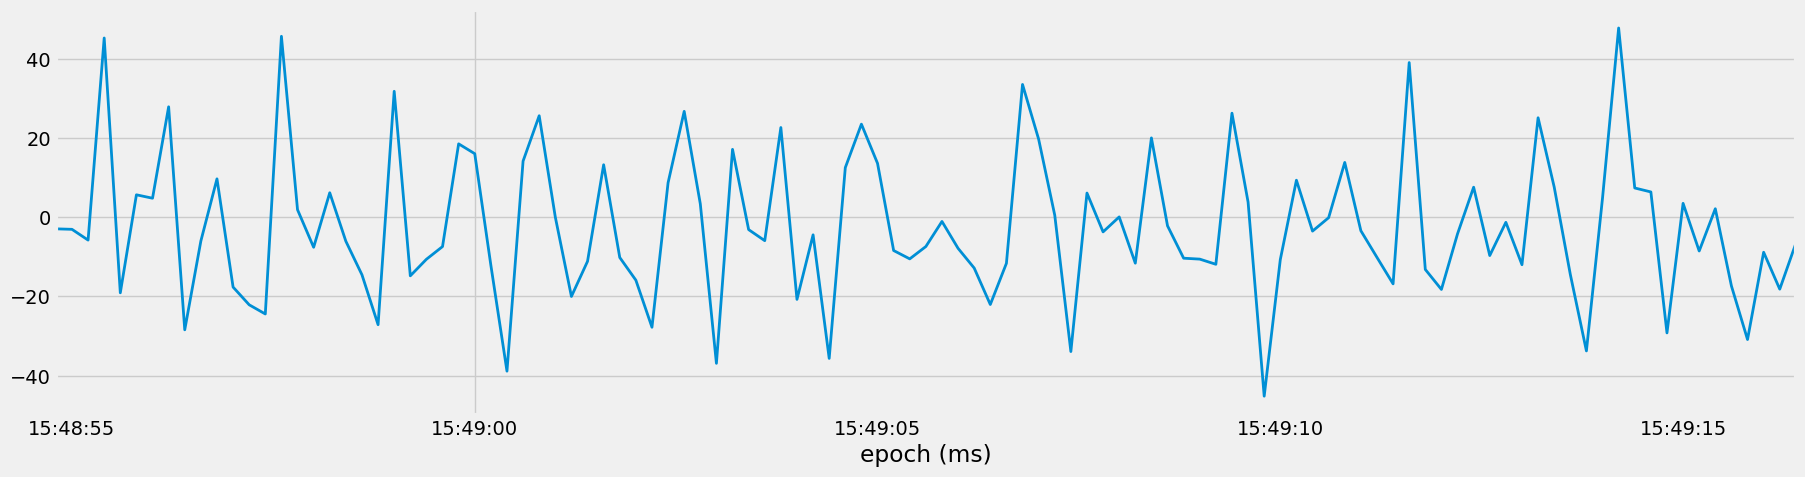

In [65]:
subset=df[df['set']==35]['gyr_y'].plot()

### Calculation of average duration of each set

<Axes: xlabel='epoch (ms)'>

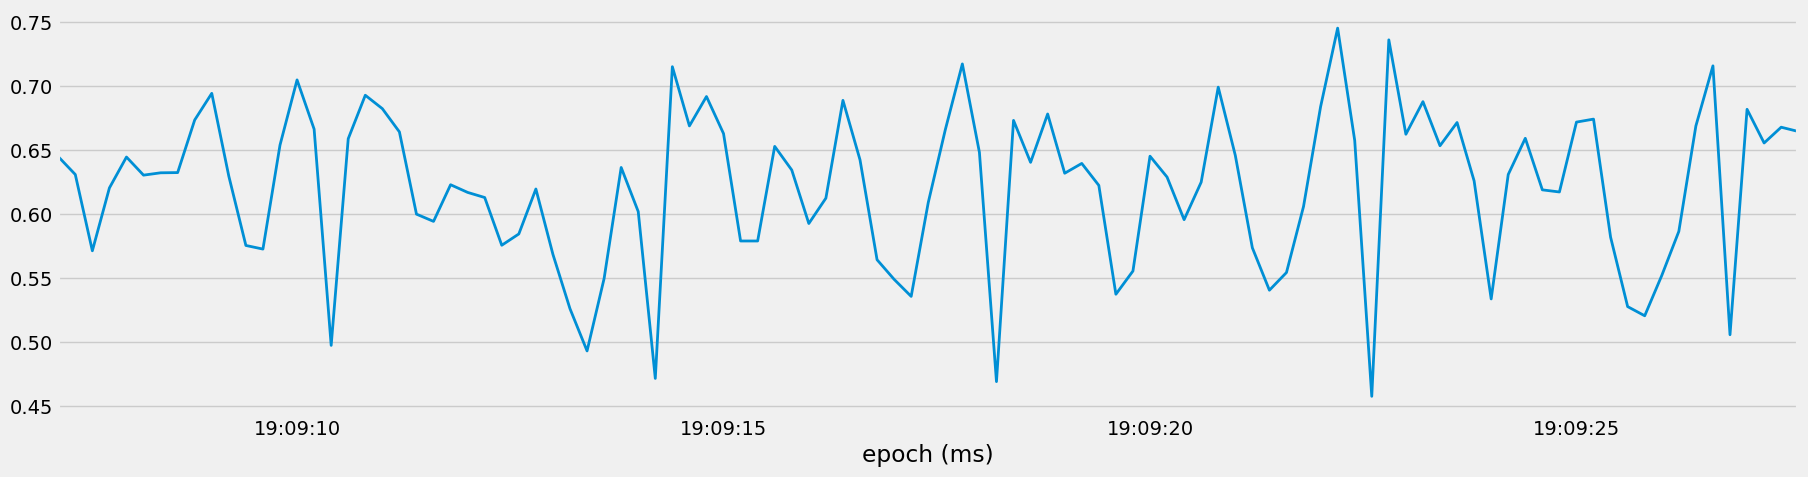

In [66]:
df[df['set']==25]['acc_y'].plot()

### We have to remove the noise which we can see from the above plot.In the above plot noise is determined by the sudden changes in the acceleration resulting in some peak values of acc_y

In [67]:
duration=df[df['set']==25].index[-1]-df[df['set']==25].index[0]

In [68]:
duration.seconds

20

In [69]:
for s in df['set'].unique():
    duration=df[df['set']==s].index[-1]-df[df['set']==s].index[0]
    df.loc[(df['set']==s),'duration']=duration
duration_df=df.groupby(df['category'])['duration']
duration_df
    
    

In [70]:
for name,group in duration_df:
    print(group)


epoch (ms)
2019-01-11 15:08:05.200   0 days 00:00:16.800000
2019-01-11 15:08:05.400   0 days 00:00:16.800000
2019-01-11 15:08:05.600   0 days 00:00:16.800000
2019-01-11 15:08:05.800   0 days 00:00:16.800000
2019-01-11 15:08:06.000   0 days 00:00:16.800000
                                   ...          
2019-01-18 17:04:06.800          0 days 00:00:16
2019-01-18 17:04:07.000          0 days 00:00:16
2019-01-18 17:04:07.200          0 days 00:00:16
2019-01-18 17:04:07.400          0 days 00:00:16
2019-01-18 17:04:07.600          0 days 00:00:16
Name: duration, Length: 3462, dtype: timedelta64[ns]
epoch (ms)
2019-01-11 15:48:54.800   0 days 00:00:21.600000
2019-01-11 15:48:55.000   0 days 00:00:21.600000
2019-01-11 15:48:55.200   0 days 00:00:21.600000
2019-01-11 15:48:55.400   0 days 00:00:21.600000
2019-01-11 15:48:55.600   0 days 00:00:21.600000
                                   ...          
2019-01-20 17:33:27.000   0 days 00:00:19.400000
2019-01-20 17:33:27.200   0 days 00:00:19.4

In [71]:
duration_df=df.groupby(df['category'])['duration'].mean()
duration_df

category
heavy      0 days 00:00:15.124090121
medium     0 days 00:00:25.347577191
sitting       0 days 00:00:33.800000
standing      0 days 00:00:39.800000
Name: duration, dtype: timedelta64[ns]

In [72]:
duration_df.iloc[0]

Timedelta('0 days 00:00:15.124090121')

### Butterworth Low pass filter

In [73]:
df_lowpass=df.copy()

In [74]:
LowPass=LowPassFilter()

In [75]:
df

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,duration
epoch (ms),,,,,,,,,,,
2019-01-11 15:08:05.200,0.013500,0.977000,-0.071000,-1.8904,2.4392,0.9388,B,bench,heavy,30,0 days 00:00:16.800000
2019-01-11 15:08:05.400,-0.001500,0.970500,-0.079500,-1.6826,-0.8904,2.1708,B,bench,heavy,30,0 days 00:00:16.800000
2019-01-11 15:08:05.600,0.001333,0.971667,-0.064333,2.5608,-0.2560,-1.4146,B,bench,heavy,30,0 days 00:00:16.800000
2019-01-11 15:08:05.800,-0.024000,0.957000,-0.073500,8.0610,-4.5244,-2.0730,B,bench,heavy,30,0 days 00:00:16.800000
2019-01-11 15:08:06.000,-0.028000,0.957667,-0.115000,2.4390,-1.5486,-3.6098,B,bench,heavy,30,0 days 00:00:16.800000
...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.048000,-1.041500,-0.076500,1.4146,-5.6218,0.2926,E,row,medium,90,0 days 00:00:19.400000
2019-01-20 17:33:27.200,-0.037000,-1.030333,-0.053333,-2.7684,-0.5854,2.2440,E,row,medium,90,0 days 00:00:19.400000
2019-01-20 17:33:27.400,-0.060000,-1.031000,-0.082000,2.8416,-5.1342,-0.1220,E,row,medium,90,0 days 00:00:19.400000


### Here we observe that for every row there is time difference of 200ms as we have set the time to 200ms
### so if we happen to define the frequency that repetition of that action it will be 1000/200=5s-1

In [76]:
fs=1000/200
cutoff=1#cutoff frequency

In [77]:
LowPass.low_pass_filter(data_table=df_lowpass,col='acc_y',sampling_frequency=fs,cutoff_frequency=cutoff,order=5)

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,duration,acc_y_lowpass
epoch (ms),,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013500,0.977000,-0.071000,-1.8904,2.4392,0.9388,B,bench,heavy,30,0 days 00:00:16.800000,0.977049
2019-01-11 15:08:05.400,-0.001500,0.970500,-0.079500,-1.6826,-0.8904,2.1708,B,bench,heavy,30,0 days 00:00:16.800000,0.962307
2019-01-11 15:08:05.600,0.001333,0.971667,-0.064333,2.5608,-0.2560,-1.4146,B,bench,heavy,30,0 days 00:00:16.800000,0.966351
2019-01-11 15:08:05.800,-0.024000,0.957000,-0.073500,8.0610,-4.5244,-2.0730,B,bench,heavy,30,0 days 00:00:16.800000,0.979259
2019-01-11 15:08:06.000,-0.028000,0.957667,-0.115000,2.4390,-1.5486,-3.6098,B,bench,heavy,30,0 days 00:00:16.800000,0.966566
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.048000,-1.041500,-0.076500,1.4146,-5.6218,0.2926,E,row,medium,90,0 days 00:00:19.400000,-1.010877
2019-01-20 17:33:27.200,-0.037000,-1.030333,-0.053333,-2.7684,-0.5854,2.2440,E,row,medium,90,0 days 00:00:19.400000,-0.986139
2019-01-20 17:33:27.400,-0.060000,-1.031000,-0.082000,2.8416,-5.1342,-0.1220,E,row,medium,90,0 days 00:00:19.400000,-1.026145


In [78]:
subset=df_lowpass[df_lowpass['set']==45]
subset

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,duration,acc_y_lowpass
epoch (ms),,,,,,,,,,,,
2019-01-14 13:54:34.800,-0.058500,1.412000,0.602500,-0.24400,10.3902,-22.8172,C,ohp,heavy,45,0 days 00:00:15.600000,1.211633
2019-01-14 13:54:35.000,-0.202000,1.180333,0.435667,39.34160,60.0244,-85.0976,C,ohp,heavy,45,0 days 00:00:15.600000,1.097067
2019-01-14 13:54:35.200,-0.297500,0.640500,0.199500,-16.15860,38.1828,22.1830,C,ohp,heavy,45,0 days 00:00:15.600000,0.841495
2019-01-14 13:54:35.400,-0.232333,0.759667,0.157667,-1.68300,5.7682,75.4634,C,ohp,heavy,45,0 days 00:00:15.600000,0.652357
2019-01-14 13:54:35.600,-0.081500,0.513500,0.028500,16.40240,-5.8048,27.0122,C,ohp,heavy,45,0 days 00:00:15.600000,0.670551
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-14 13:54:49.600,-0.322000,0.800500,0.046500,11.04900,-19.2316,-33.7560,C,ohp,heavy,45,0 days 00:00:15.600000,0.772735
2019-01-14 13:54:49.800,-0.394667,0.811333,0.061667,12.65860,-23.6706,-12.1338,C,ohp,heavy,45,0 days 00:00:15.600000,0.777915
2019-01-14 13:54:50.000,-0.400000,0.920500,0.117000,27.34140,-40.7318,53.9024,C,ohp,heavy,45,0 days 00:00:15.600000,0.920860


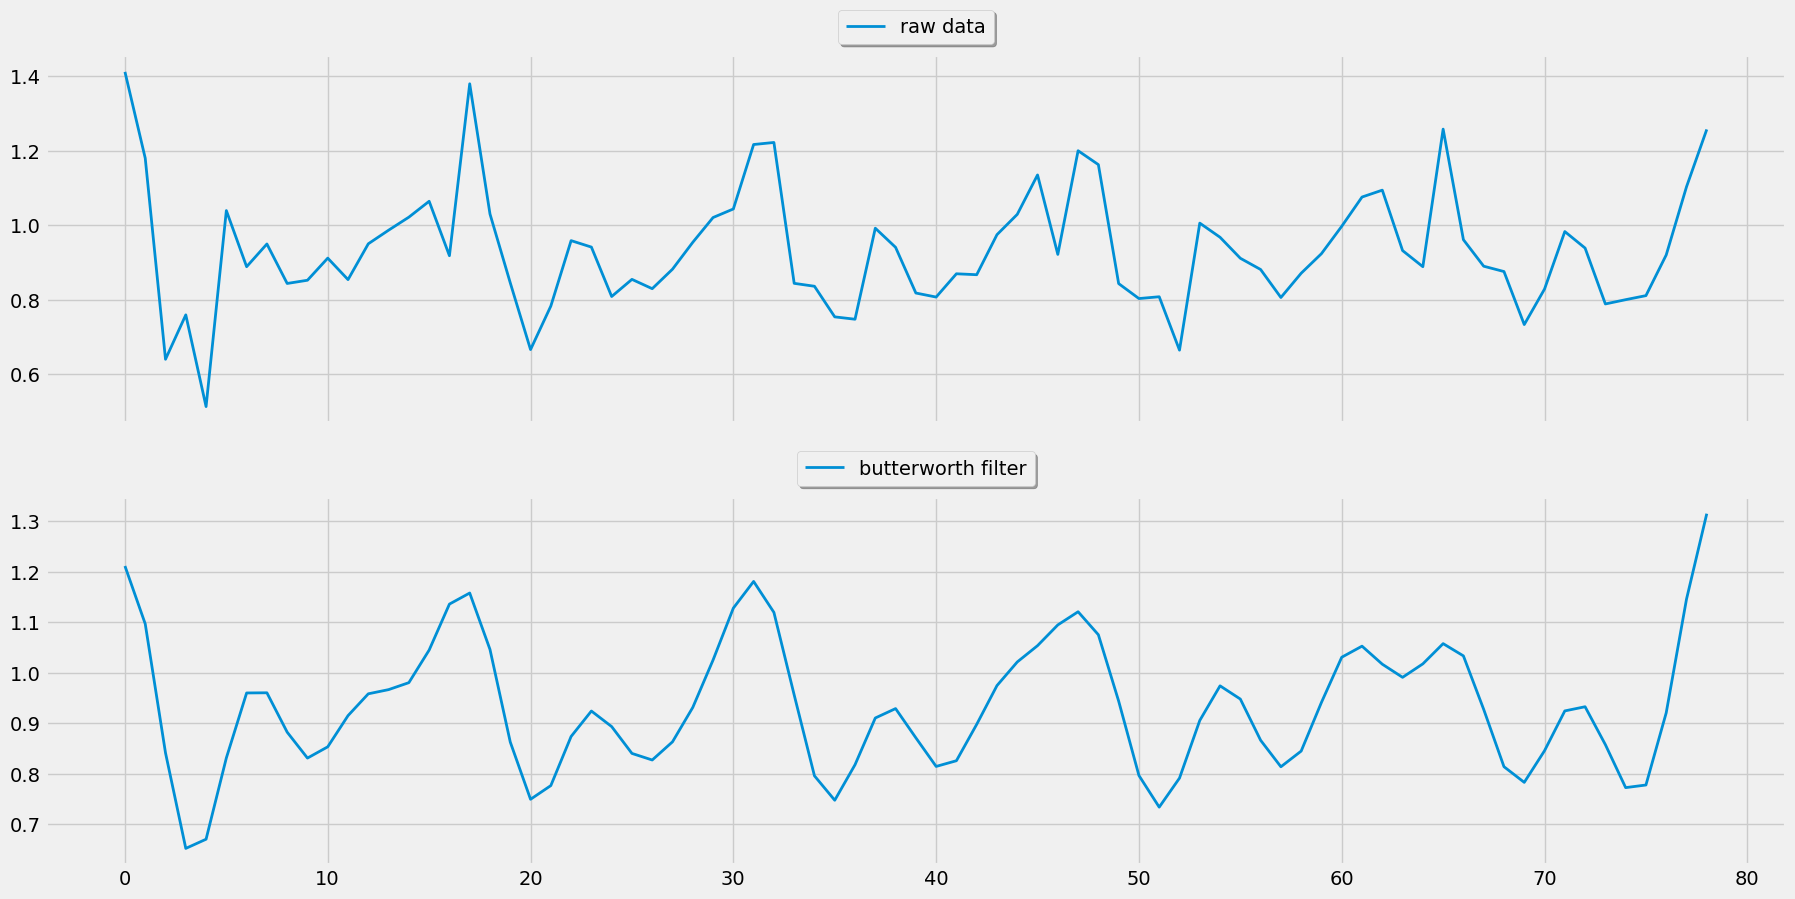

In [79]:
fig,ax=plt.subplots(nrows=2,sharex=True,figsize=(20,10))
ax[0].plot(subset['acc_y'].reset_index(drop=True),label='raw data')
ax[1].plot(subset['acc_y_lowpass'].reset_index(drop=True),label='butterworth filter')
ax[0].legend(loc='upper center',bbox_to_anchor=(0.5,1.15),fancybox=True,shadow=True)
ax[1].legend(loc='upper center',bbox_to_anchor=(0.5,1.15),fancybox=True,shadow=True)

### Applying low_pass_filter over the predictor columns

In [80]:
for col in predictor_columns:
    df_lowpass=LowPass.low_pass_filter(df_lowpass,col,fs,cutoff,order=5)
    df_lowpass[col]=df_lowpass[col+'_lowpass']
    del df_lowpass[col+'_lowpass']

In [81]:
df_lowpass

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,duration
epoch (ms),,,,,,,,,,,
2019-01-11 15:08:05.200,0.013501,0.977049,-0.070982,-1.900465,2.437780,0.940880,B,bench,heavy,30,0 days 00:00:16.800000
2019-01-11 15:08:05.400,-0.004111,0.962307,-0.075309,1.437860,-0.522120,0.476150,B,bench,heavy,30,0 days 00:00:16.800000
2019-01-11 15:08:05.600,-0.014143,0.966351,-0.074978,1.633730,-2.981339,1.302906,B,bench,heavy,30,0 days 00:00:16.800000
2019-01-11 15:08:05.800,-0.013047,0.979259,-0.074482,1.092197,-3.156357,0.501259,B,bench,heavy,30,0 days 00:00:16.800000
2019-01-11 15:08:06.000,-0.010429,0.966566,-0.088632,5.070302,0.248676,-5.951031,B,bench,heavy,30,0 days 00:00:16.800000
...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.048043,-1.010877,-0.077600,7.204016,-5.207856,-0.681873,E,row,medium,90,0 days 00:00:19.400000
2019-01-20 17:33:27.200,-0.046788,-0.986139,-0.055736,2.208068,-3.456089,0.133057,E,row,medium,90,0 days 00:00:19.400000
2019-01-20 17:33:27.400,-0.045416,-1.026145,-0.056200,-2.408598,-1.581380,1.525886,E,row,medium,90,0 days 00:00:19.400000


### Principal Component Analysis

In [82]:
df_pca=df_lowpass.copy()
Pca=PrincipalComponentAnalysis()
pc_values=Pca.determine_pc_explained_variance(df_pca,predictor_columns)
pc_values

array([0.58969625, 0.28216661, 0.06624672, 0.03606247, 0.01573649,
       0.01009146])

In [83]:
predictor_columns

['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']

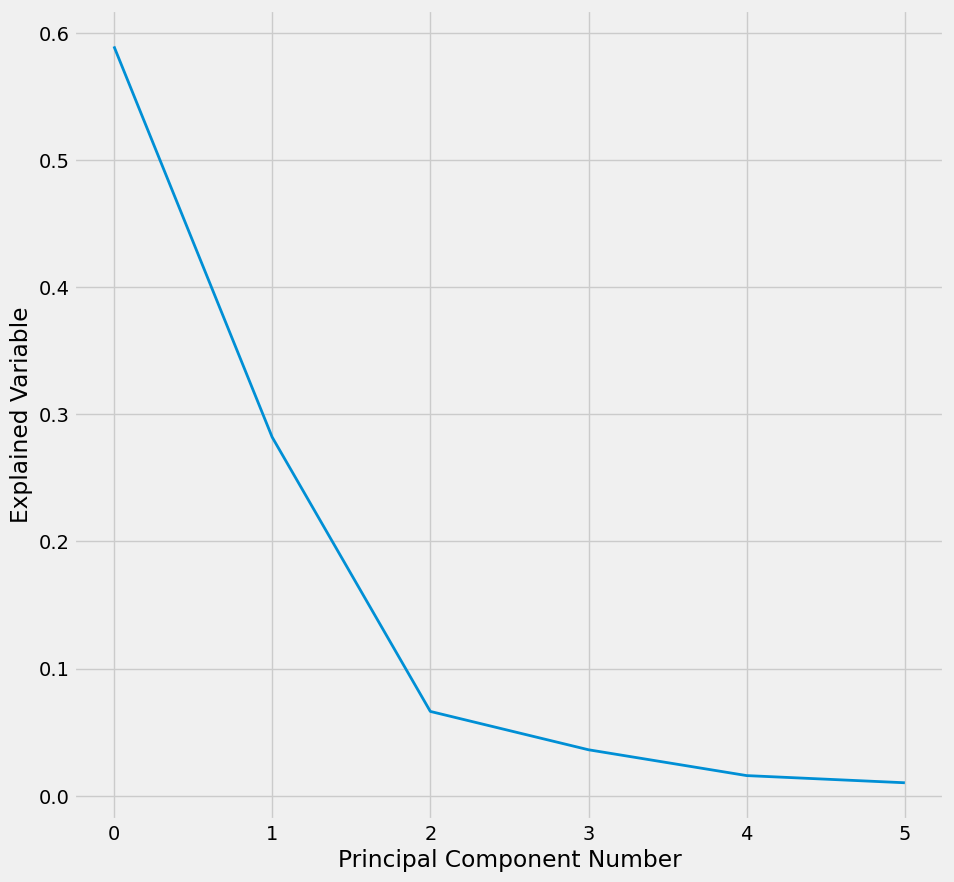

In [84]:
plt.figure(figsize=(10,10))
plt.plot(range(0,len(predictor_columns)),pc_values)
plt.xlabel('Principal Component Number')
plt.ylabel('Explained Variable')
plt.show()

In [85]:
df_pca=Pca.apply_pca(df_pca,predictor_columns,3)

In [86]:
df_pca

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,duration,pca_1,pca_2,pca_3
epoch (ms),,,,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013501,0.977049,-0.070982,-1.900465,2.437780,0.940880,B,bench,heavy,30,0 days 00:00:16.800000,-0.315571,-0.075666,0.074674
2019-01-11 15:08:05.400,-0.004111,0.962307,-0.075309,1.437860,-0.522120,0.476150,B,bench,heavy,30,0 days 00:00:16.800000,-0.312177,-0.081942,0.066969
2019-01-11 15:08:05.600,-0.014143,0.966351,-0.074978,1.633730,-2.981339,1.302906,B,bench,heavy,30,0 days 00:00:16.800000,-0.314428,-0.083404,0.062456
2019-01-11 15:08:05.800,-0.013047,0.979259,-0.074482,1.092197,-3.156357,0.501259,B,bench,heavy,30,0 days 00:00:16.800000,-0.318716,-0.082454,0.063487
2019-01-11 15:08:06.000,-0.010429,0.966566,-0.088632,5.070302,0.248676,-5.951031,B,bench,heavy,30,0 days 00:00:16.800000,-0.314476,-0.090816,0.067612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.048043,-1.010877,-0.077600,7.204016,-5.207856,-0.681873,E,row,medium,90,0 days 00:00:19.400000,0.355080,-0.161175,-0.054196
2019-01-20 17:33:27.200,-0.046788,-0.986139,-0.055736,2.208068,-3.456089,0.133057,E,row,medium,90,0 days 00:00:19.400000,0.347298,-0.147004,-0.057614
2019-01-20 17:33:27.400,-0.045416,-1.026145,-0.056200,-2.408598,-1.581380,1.525886,E,row,medium,90,0 days 00:00:19.400000,0.360942,-0.148305,-0.059240


In [87]:
subset=df_pca[df_pca['set']==35]

<Axes: xlabel='epoch (ms)'>

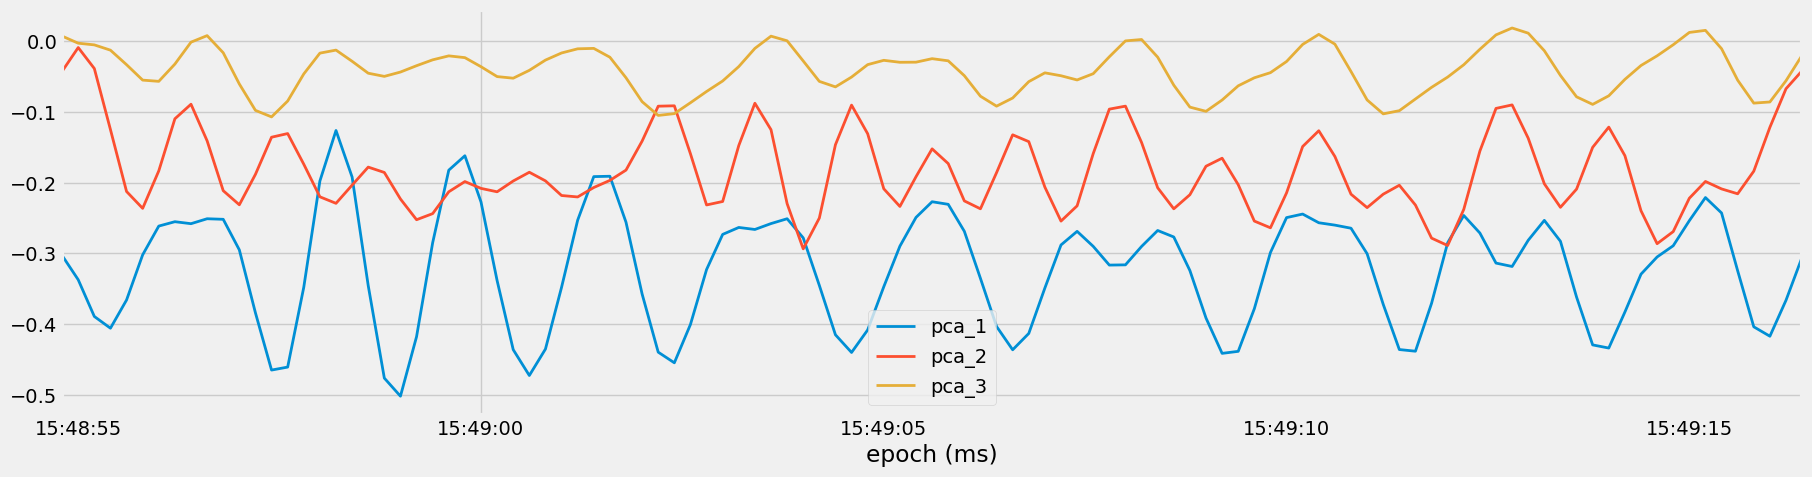

In [88]:
subset[['pca_1','pca_2','pca_3']].plot()

In [89]:
df_squared=df_pca.copy()
acc_r=df_squared['acc_x']**2 + df_squared['acc_y']**2 + df_squared['acc_z']**2
gyr_r=df_squared['gyr_x']**2 + df_squared['gyr_y']**2 + df_squared['gyr_z']**2


In [90]:
df_squared['acc_r']=np.sqrt(acc_r)
df_squared['gyr_r']=np.sqrt(gyr_r)

In [91]:
df_squared

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,duration,pca_1,pca_2,pca_3,acc_r,gyr_r
epoch (ms),,,,,,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013501,0.977049,-0.070982,-1.900465,2.437780,0.940880,B,bench,heavy,30,0 days 00:00:16.800000,-0.315571,-0.075666,0.074674,0.979717,3.231067
2019-01-11 15:08:05.400,-0.004111,0.962307,-0.075309,1.437860,-0.522120,0.476150,B,bench,heavy,30,0 days 00:00:16.800000,-0.312177,-0.081942,0.066969,0.965258,1.602114
2019-01-11 15:08:05.600,-0.014143,0.966351,-0.074978,1.633730,-2.981339,1.302906,B,bench,heavy,30,0 days 00:00:16.800000,-0.314428,-0.083404,0.062456,0.969359,3.640745
2019-01-11 15:08:05.800,-0.013047,0.979259,-0.074482,1.092197,-3.156357,0.501259,B,bench,heavy,30,0 days 00:00:16.800000,-0.318716,-0.082454,0.063487,0.982174,3.377387
2019-01-11 15:08:06.000,-0.010429,0.966566,-0.088632,5.070302,0.248676,-5.951031,B,bench,heavy,30,0 days 00:00:16.800000,-0.314476,-0.090816,0.067612,0.970677,7.822057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.048043,-1.010877,-0.077600,7.204016,-5.207856,-0.681873,E,row,medium,90,0 days 00:00:19.400000,0.355080,-0.161175,-0.054196,1.014989,8.915412
2019-01-20 17:33:27.200,-0.046788,-0.986139,-0.055736,2.208068,-3.456089,0.133057,E,row,medium,90,0 days 00:00:19.400000,0.347298,-0.147004,-0.057614,0.988820,4.103391
2019-01-20 17:33:27.400,-0.045416,-1.026145,-0.056200,-2.408598,-1.581380,1.525886,E,row,medium,90,0 days 00:00:19.400000,0.360942,-0.148305,-0.059240,1.028686,3.260435


array([<Axes: xlabel='epoch (ms)'>, <Axes: xlabel='epoch (ms)'>],
      dtype=object)

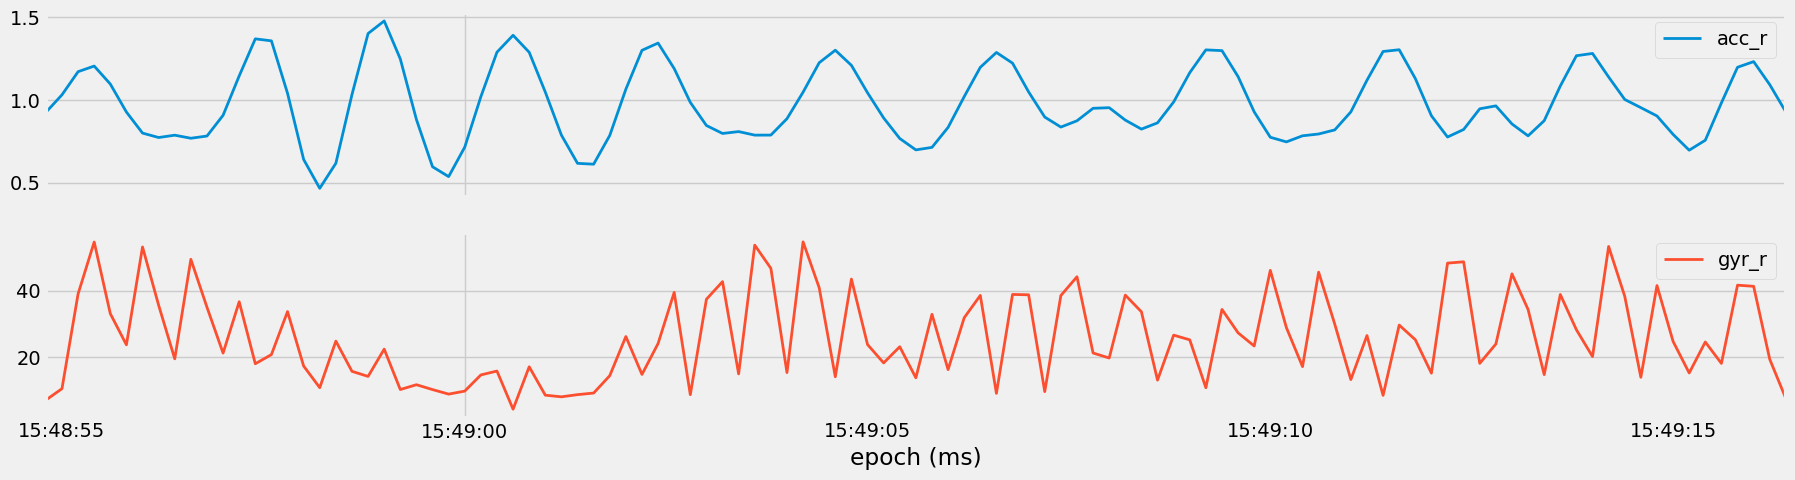

In [92]:
subset=df_squared[df_squared['set']==35]
subset[['acc_r','gyr_r']].plot(subplots=True)

In [93]:
df_temporal=df_squared.copy()

In [94]:
NumAbs=NumericalAbstraction()

In [95]:
predictor_columns=predictor_columns+['acc_r','gyr_r']
predictor_columns

['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z', 'acc_r', 'gyr_r']

In [96]:
ws= int(1000/200)

In [97]:
for col in predictor_columns:
    df_temporal=NumAbs.abstract_numerical(df_temporal,[col],ws,'mean')
    df_temporal=NumAbs.abstract_numerical(df_temporal,[col],ws,'std')
df_temporal

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,...,gyr_x_temp_mean_ws_5,gyr_x_temp_std_ws_5,gyr_y_temp_mean_ws_5,gyr_y_temp_std_ws_5,gyr_z_temp_mean_ws_5,gyr_z_temp_std_ws_5,acc_r_temp_mean_ws_5,acc_r_temp_std_ws_5,gyr_r_temp_mean_ws_5,gyr_r_temp_std_ws_5
epoch (ms),,,,,,,,,,,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013501,0.977049,-0.070982,-1.900465,2.437780,0.940880,B,bench,heavy,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.400,-0.004111,0.962307,-0.075309,1.437860,-0.522120,0.476150,B,bench,heavy,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.600,-0.014143,0.966351,-0.074978,1.633730,-2.981339,1.302906,B,bench,heavy,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.800,-0.013047,0.979259,-0.074482,1.092197,-3.156357,0.501259,B,bench,heavy,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:06.000,-0.010429,0.966566,-0.088632,5.070302,0.248676,-5.951031,B,bench,heavy,30,...,1.466725,2.213266,-0.794672,2.096219,-0.545967,2.719749,0.973437,0.006433,3.934674,2.070971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.048043,-1.010877,-0.077600,7.204016,-5.207856,-0.681873,E,row,medium,90,...,-11.188688,15.180812,0.342197,4.435035,7.086911,5.835204,1.072404,0.096242,18.278373,11.207382
2019-01-20 17:33:27.200,-0.046788,-0.986139,-0.055736,2.208068,-3.456089,0.133057,E,row,medium,90,...,-4.903996,12.722496,-1.460787,3.723107,4.423421,5.341121,1.086615,0.075334,12.571093,9.590013
2019-01-20 17:33:27.400,-0.045416,-1.026145,-0.056200,-2.408598,-1.581380,1.525886,E,row,medium,90,...,0.060610,6.225381,-2.767009,1.984758,2.050517,2.914563,1.069795,0.076983,7.073825,3.607623


In [99]:
df_temporal['set'].unique()

array([30,  1, 31,  3,  9, 32, 10, 33, 11, 34, 35, 15, 36, 16, 37, 17, 27,
       38, 28, 29,  6, 65, 67, 73,  4,  2, 39, 40, 12, 41, 13, 45, 14, 46,
       51, 22, 47, 23, 49, 68, 66, 76, 77, 78, 52, 83, 48, 85, 50, 24, 53,
       25, 54, 26, 55,  7, 42,  8, 43,  5, 44, 84, 86, 92, 93, 74, 75, 72,
       63, 64, 62, 56, 57, 18, 58, 20, 59, 60, 61, 69, 70, 19, 71, 21, 87,
       89, 91, 80, 82, 88, 90])

subset[['acc_y','acc_y_temp_mean_ws_5','acc_y_temp_std_ws_5']].plot()  

In [100]:
df_temporal_list = []

for s in df_temporal['set'].unique():
    subset = df_temporal[df_temporal['set'] == s].copy()
    
    for col in predictor_columns:
        subset = NumAbs.abstract_numerical(subset, [col], ws, 'mean')
        subset = NumAbs.abstract_numerical(subset, [col], ws, 'std')
    
    df_temporal_list.append(subset)

df_temporal = pd.concat(df_temporal_list)
df_temporal.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9009 entries, 2019-01-11 15:08:05.200000 to 2019-01-20 17:33:27.800000
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype          
---  ------                --------------  -----          
 0   acc_x                 9009 non-null   float64        
 1   acc_y                 9009 non-null   float64        
 2   acc_z                 9009 non-null   float64        
 3   gyr_x                 9009 non-null   float64        
 4   gyr_y                 9009 non-null   float64        
 5   gyr_z                 9009 non-null   float64        
 6   participant           9009 non-null   object         
 7   label                 9009 non-null   object         
 8   category              9009 non-null   object         
 9   set                   9009 non-null   int32          
 10  duration              9009 non-null   timedelta64[ns]
 11  pca_1                 9009 non-null   float64        
 12  pca_2       

<Axes: xlabel='epoch (ms)'>

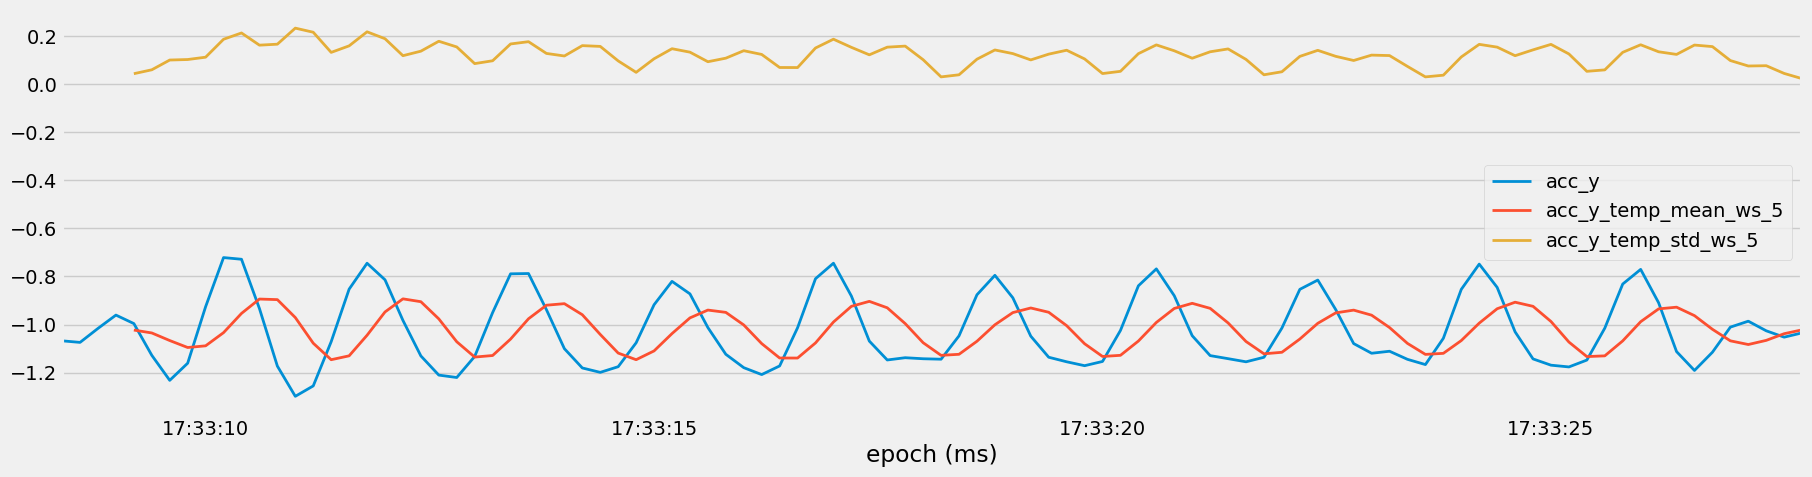

In [101]:

subset[['acc_y','acc_y_temp_mean_ws_5','acc_y_temp_std_ws_5']].plot()  

<Axes: xlabel='epoch (ms)'>

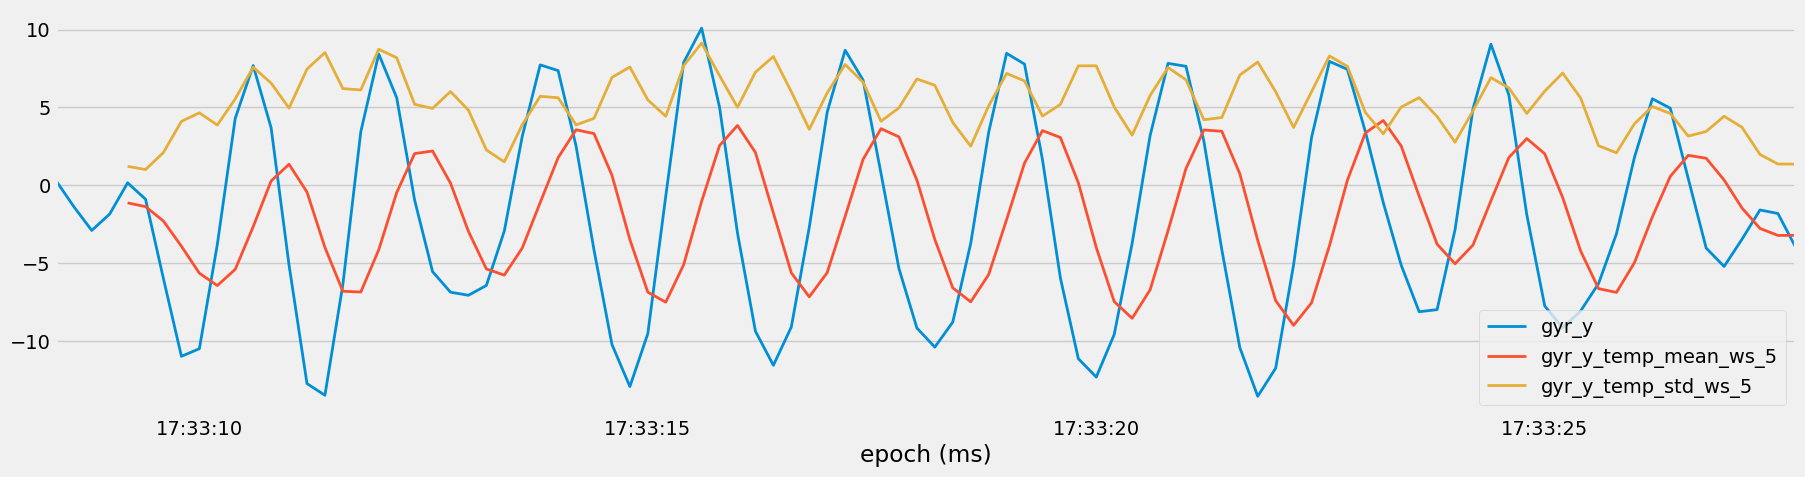

In [102]:
subset[['gyr_y','gyr_y_temp_mean_ws_5','gyr_y_temp_std_ws_5']].plot()  

In [121]:
df_freq=df_temporal.copy().reset_index()

In [122]:
import numpy as np
class FourierTransformation:
    def find_fft_transformation(self, data, sampling_rate):
        
        transformation = np.fft.rfft(data, len(data))
        return transformation.real, transformation.imag

    
    def abstract_frequency(self, data_table, cols, window_size, sampling_rate):

    
        freqs = np.fft.rfftfreq(int(window_size)) *sampling_rate

        for col in cols:
            data_table[col + '_max_freq'] = np.nan
            data_table[col + '_freq_weighted'] = np.nan
            data_table[col + '_pse'] = np.nan
            for freq in freqs:
                data_table[col + '_freq_' + str(freq) + '_Hz_ws_' + str(window_size)] = np.nan

        for i in range(window_size, len(data_table.index)):
            for col in cols:
                real_ampl, imag_ampl = self.find_fft_transformation(data_table[col][i-window_size:min(i+1, len(data_table.index))], sampling_rate)
               
                for j in range(0, len(freqs)):
                    data_table.loc[i, col + '_freq_' + str(freqs[j]) + '_Hz_ws_' + str(window_size)] = real_ampl[j]

                data_table.loc[i, col + '_max_freq'] = freqs[np.argmax(real_ampl[0:len(real_ampl)])]
                data_table.loc[i, col + '_freq_weighted'] = float(np.sum(freqs * real_ampl)) / np.sum(real_ampl)
                PSD = np.divide(np.square(real_ampl),float(len(real_ampl)))
                PSD_pdf = np.divide(PSD, np.sum(PSD))
                data_table.loc[i, col + '_pse'] = -np.sum(np.log(PSD_pdf) * PSD_pdf)

        return data_table


In [123]:
FreqAbs=FourierTransformation()

In [124]:
fs=int(1000/200)
ws=int(2000/200)

In [125]:
df_freq=FreqAbs.abstract_frequency(df_freq,['acc_y'],ws,fs)

In [126]:
df_freq

,epoch (ms),acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,...,gyr_r_temp_std_ws_5,acc_y_max_freq,acc_y_freq_weighted,acc_y_pse,acc_y_freq_0.0_Hz_ws_10,acc_y_freq_0.5_Hz_ws_10,acc_y_freq_1.0_Hz_ws_10,acc_y_freq_1.5000000000000002_Hz_ws_10,acc_y_freq_2.0_Hz_ws_10,acc_y_freq_2.5_Hz_ws_10
0,2019-01-11 15:08:05.200,0.013501,0.977049,-0.070982,-1.900465,2.437780,0.940880,B,bench,heavy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-11 15:08:05.400,-0.004111,0.962307,-0.075309,1.437860,-0.522120,0.476150,B,bench,heavy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-11 15:08:05.600,-0.014143,0.966351,-0.074978,1.633730,-2.981339,1.302906,B,bench,heavy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-11 15:08:05.800,-0.013047,0.979259,-0.074482,1.092197,-3.156357,0.501259,B,bench,heavy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-11 15:08:06.000,-0.010429,0.966566,-0.088632,5.070302,0.248676,-5.951031,B,bench,heavy,...,2.070971,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9004,2019-01-20 17:33:27.000,-0.048043,-1.010877,-0.077600,7.204016,-5.207856,-0.681873,E,row,medium,...,11.207382,1.0,0.053418,0.039295,-11.450098,-0.750001,0.384353,-0.138046,-0.103211,-0.098064
9005,2019-01-20 17:33:27.200,-0.046788,-0.986139,-0.055736,2.208068,-3.456089,0.133057,E,row,medium,...,9.590013,1.5,0.076589,0.013344,-11.267143,-0.311362,-0.289929,-0.063869,-0.085984,-0.085455
9006,2019-01-20 17:33:27.400,-0.045416,-1.026145,-0.056200,-2.408598,-1.581380,1.525886,E,row,medium,...,3.607623,0.5,0.086496,0.031856,-11.116894,0.169574,-0.745774,-0.048113,-0.065521,-0.065067
9007,2019-01-20 17:33:27.600,-0.044925,-1.052548,-0.061608,-2.376623,-1.808121,1.788398,E,row,medium,...,2.109095,0.5,0.042065,0.028864,-11.021560,0.526623,-0.440329,-0.086253,-0.040880,-0.031403


In [129]:
df_freq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9009 entries, 0 to 9008
Data columns (total 42 columns):
 #   Column                                  Non-Null Count  Dtype          
---  ------                                  --------------  -----          
 0   epoch (ms)                              9009 non-null   datetime64[ns] 
 1   acc_x                                   9009 non-null   float64        
 2   acc_y                                   9009 non-null   float64        
 3   acc_z                                   9009 non-null   float64        
 4   gyr_x                                   9009 non-null   float64        
 5   gyr_y                                   9009 non-null   float64        
 6   gyr_z                                   9009 non-null   float64        
 7   participant                             9009 non-null   object         
 8   label                                   9009 non-null   object         
 9   category                                9

<Axes: >

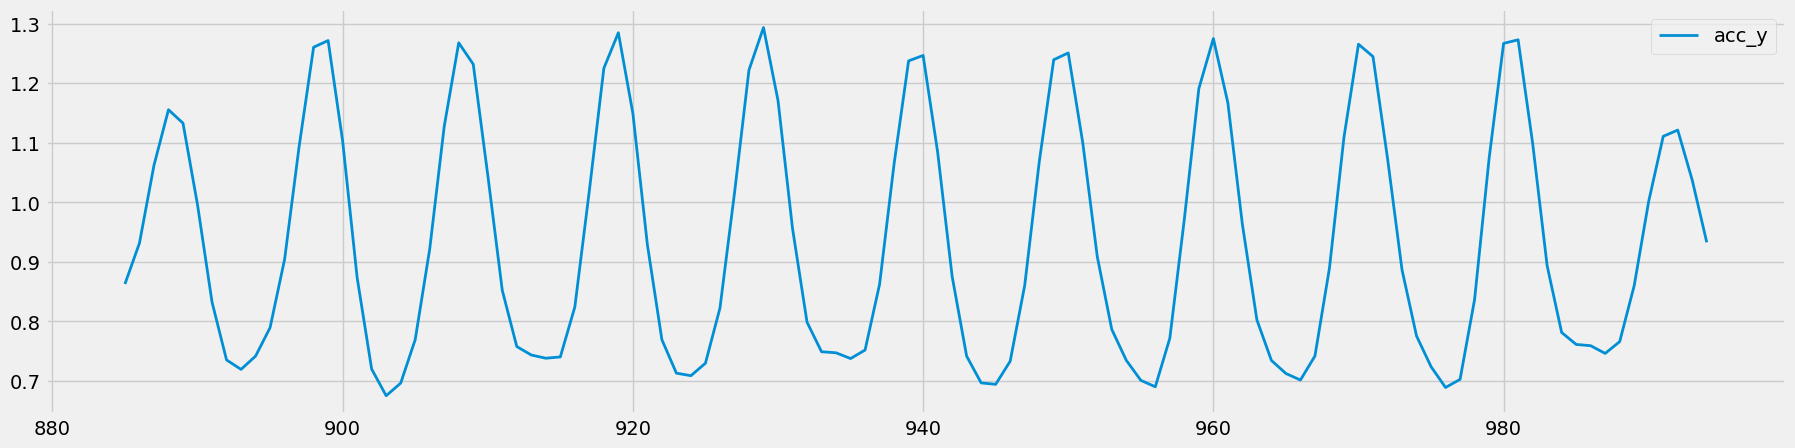

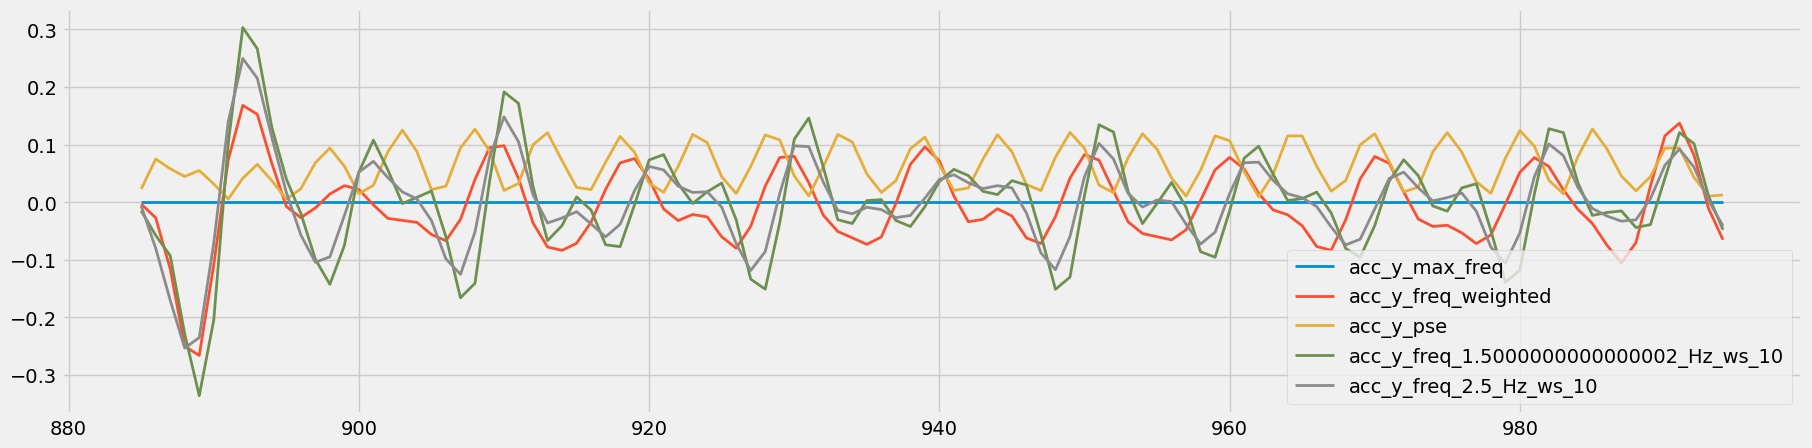

In [131]:
subset=df_freq[df_freq['set']==15]
subset[['acc_y']].plot()
subset[['acc_y_max_freq','acc_y_freq_weighted','acc_y_pse','acc_y_freq_1.5000000000000002_Hz_ws_10','acc_y_freq_2.5_Hz_ws_10']].plot()

In [132]:
df_frequency_list = []

for s in df_freq['set'].unique():
    print('Applying Forier Transformation to set {}'.format(s))
    subset = df_freq[df_freq['set'] == s].reset_index(drop=True).copy()
    subset = FreqAbs.abstract_frequency(subset, predictor_columns, ws, fs)
    
    df_frequency_list.append(subset)


Applying Forier Transformation to set 30
Applying Forier Transformation to set 1
Applying Forier Transformation to set 31
Applying Forier Transformation to set 3
Applying Forier Transformation to set 9
Applying Forier Transformation to set 32
Applying Forier Transformation to set 10
Applying Forier Transformation to set 33
Applying Forier Transformation to set 11
Applying Forier Transformation to set 34
Applying Forier Transformation to set 35
Applying Forier Transformation to set 15
Applying Forier Transformation to set 36
Applying Forier Transformation to set 16
Applying Forier Transformation to set 37
Applying Forier Transformation to set 17
Applying Forier Transformation to set 27
Applying Forier Transformation to set 38
Applying Forier Transformation to set 28
Applying Forier Transformation to set 29
Applying Forier Transformation to set 6
Applying Forier Transformation to set 65
Applying Forier Transformation to set 67
Applying Forier Transformation to set 73
Applying Forier Tran

In [135]:
df_freq=pd.concat(df_frequency_list).set_index('epoch (ms)',drop=True)

In [136]:
df_freq

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,...,acc_r_freq_2.5_Hz_ws_10,gyr_r_max_freq,gyr_r_freq_weighted,gyr_r_pse,gyr_r_freq_0.0_Hz_ws_10,gyr_r_freq_0.5_Hz_ws_10,gyr_r_freq_1.0_Hz_ws_10,gyr_r_freq_1.5000000000000002_Hz_ws_10,gyr_r_freq_2.0_Hz_ws_10,gyr_r_freq_2.5_Hz_ws_10
epoch (ms),,,,,,,,,,,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013501,0.977049,-0.070982,-1.900465,2.437780,0.940880,B,bench,heavy,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.400,-0.004111,0.962307,-0.075309,1.437860,-0.522120,0.476150,B,bench,heavy,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.600,-0.014143,0.966351,-0.074978,1.633730,-2.981339,1.302906,B,bench,heavy,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.800,-0.013047,0.979259,-0.074482,1.092197,-3.156357,0.501259,B,bench,heavy,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:06.000,-0.010429,0.966566,-0.088632,5.070302,0.248676,-5.951031,B,bench,heavy,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.048043,-1.010877,-0.077600,7.204016,-5.207856,-0.681873,E,row,medium,90,...,0.099413,0.0,-0.387805,0.158968,209.522356,-33.095067,-16.119556,-4.063167,-3.043128,-5.043327
2019-01-20 17:33:27.200,-0.046788,-0.986139,-0.055736,2.208068,-3.456089,0.133057,E,row,medium,90,...,0.088495,0.0,0.069343,0.316732,205.735395,-14.997181,36.588110,-35.770048,9.589154,7.954785
2019-01-20 17:33:27.400,-0.045416,-1.026145,-0.056200,-2.408598,-1.581380,1.525886,E,row,medium,90,...,0.064742,0.0,0.396091,0.276932,189.680827,-1.856797,43.635708,20.316148,4.784474,8.969412


In [137]:
df_freq.dropna()

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,...,acc_r_freq_2.5_Hz_ws_10,gyr_r_max_freq,gyr_r_freq_weighted,gyr_r_pse,gyr_r_freq_0.0_Hz_ws_10,gyr_r_freq_0.5_Hz_ws_10,gyr_r_freq_1.0_Hz_ws_10,gyr_r_freq_1.5000000000000002_Hz_ws_10,gyr_r_freq_2.0_Hz_ws_10,gyr_r_freq_2.5_Hz_ws_10
epoch (ms),,,,,,,,,,,,,,,,,,,,,
2019-01-11 15:08:07.200,-0.196317,1.141973,-0.112140,-0.172969,-3.257000,-0.022611,B,bench,heavy,30,...,-0.091130,0.0,-0.076485,0.699085,109.085261,-46.276034,17.134046,-22.923868,6.752649,8.541444
2019-01-11 15:08:07.400,-0.195299,1.105491,-0.132813,14.255060,2.012875,-7.216963,B,bench,heavy,30,...,-0.060443,0.0,-0.950439,0.493756,121.958323,-40.940327,12.723877,1.352006,-5.288283,-20.014807
2019-01-11 15:08:07.600,-0.211518,1.000753,-0.184606,13.323486,2.191258,-3.183807,B,bench,heavy,30,...,-0.014727,0.0,-0.498714,0.339874,134.228971,-25.156692,-14.338317,7.919690,-20.735099,5.220027
2019-01-11 15:08:07.800,-0.210666,0.906212,-0.210327,-3.852519,-3.170730,10.957880,B,bench,heavy,30,...,0.029452,0.0,-0.654177,0.367798,142.628599,-6.590416,-33.417898,-17.072225,14.674252,-10.332383
2019-01-11 15:08:08.000,-0.164924,0.864320,-0.178538,-20.541984,-8.226941,21.708715,B,bench,heavy,30,...,0.054627,0.0,-0.933818,0.357227,170.249985,28.905231,-10.351566,-15.390989,-24.971873,-20.294482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.048043,-1.010877,-0.077600,7.204016,-5.207856,-0.681873,E,row,medium,90,...,0.099413,0.0,-0.387805,0.158968,209.522356,-33.095067,-16.119556,-4.063167,-3.043128,-5.043327
2019-01-20 17:33:27.200,-0.046788,-0.986139,-0.055736,2.208068,-3.456089,0.133057,E,row,medium,90,...,0.088495,0.0,0.069343,0.316732,205.735395,-14.997181,36.588110,-35.770048,9.589154,7.954785
2019-01-20 17:33:27.400,-0.045416,-1.026145,-0.056200,-2.408598,-1.581380,1.525886,E,row,medium,90,...,0.064742,0.0,0.396091,0.276932,189.680827,-1.856797,43.635708,20.316148,4.784474,8.969412


In [138]:
df_freq.iloc[::2] 

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,...,acc_r_freq_2.5_Hz_ws_10,gyr_r_max_freq,gyr_r_freq_weighted,gyr_r_pse,gyr_r_freq_0.0_Hz_ws_10,gyr_r_freq_0.5_Hz_ws_10,gyr_r_freq_1.0_Hz_ws_10,gyr_r_freq_1.5000000000000002_Hz_ws_10,gyr_r_freq_2.0_Hz_ws_10,gyr_r_freq_2.5_Hz_ws_10
epoch (ms),,,,,,,,,,,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013501,0.977049,-0.070982,-1.900465,2.437780,0.940880,B,bench,heavy,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.600,-0.014143,0.966351,-0.074978,1.633730,-2.981339,1.302906,B,bench,heavy,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:06.000,-0.010429,0.966566,-0.088632,5.070302,0.248676,-5.951031,B,bench,heavy,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:06.400,-0.083051,0.845294,-0.183599,15.654910,6.599949,-19.944596,B,bench,heavy,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:06.800,-0.204302,0.935063,-0.197628,-8.250776,-4.552953,0.585287,B,bench,heavy,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:26.200,0.058850,-0.909458,0.108233,-29.215392,5.558830,13.450505,E,row,medium,90,...,-0.119232,0.0,-0.853013,0.210188,241.797987,2.525738,11.075468,-27.898508,-27.186449,-25.943306
2019-01-20 17:33:26.600,-0.018615,-1.191105,-0.097478,-10.724922,0.437615,7.609956,E,row,medium,90,...,-0.122122,0.0,0.370186,0.121218,245.241670,-6.520093,3.406344,18.175922,27.000763,11.712017
2019-01-20 17:33:27.000,-0.048043,-1.010877,-0.077600,7.204016,-5.207856,-0.681873,E,row,medium,90,...,0.099413,0.0,-0.387805,0.158968,209.522356,-33.095067,-16.119556,-4.063167,-3.043128,-5.043327


In [143]:
df_freq=df_freq.dropna()
df_freq=df_freq.iloc[::2]
df_cluster=df_freq.copy()

In [144]:
cluster_columns=['acc_x','acc_y','acc_z']
k_values=range(2,10)
inertias=[]

In [148]:
for k in k_values:
    subset=df_cluster[cluster_columns]
    kmeans=KMeans(n_clusters=k,n_init=20,random_state=20)
    cluster_label=kmeans.fit_predict(subset)
    inertias.append(kmeans.inertia_)
    

C:\Users\shand\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\shand\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\shand\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\shand\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

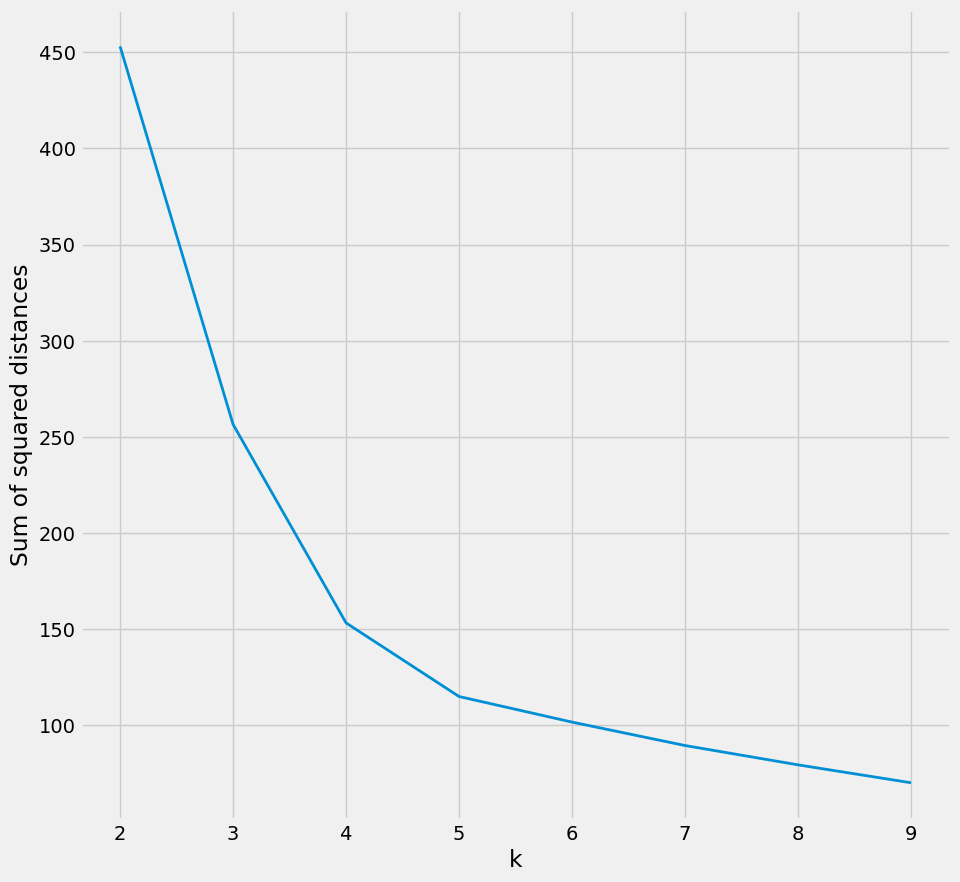

In [150]:
plt.figure(figsize=(10,10))
plt.plot(k_values,inertias)
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.show()

In [152]:

kmeans=KMeans(n_clusters=5,n_init=20,random_state=20)
subset=df_cluster[cluster_columns]
df_cluster['cluster']=kmeans.fit_predict(subset)


C:\Users\shand\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


In [153]:
df_cluster

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,...,gyr_r_max_freq,gyr_r_freq_weighted,gyr_r_pse,gyr_r_freq_0.0_Hz_ws_10,gyr_r_freq_0.5_Hz_ws_10,gyr_r_freq_1.0_Hz_ws_10,gyr_r_freq_1.5000000000000002_Hz_ws_10,gyr_r_freq_2.0_Hz_ws_10,gyr_r_freq_2.5_Hz_ws_10,cluster
epoch (ms),,,,,,,,,,,,,,,,,,,,,
2019-01-11 15:08:07.200,-0.196317,1.141973,-0.112140,-0.172969,-3.257000,-0.022611,B,bench,heavy,30,...,0.0,-0.076485,0.699085,109.085261,-46.276034,17.134046,-22.923868,6.752649,8.541444,2
2019-01-11 15:08:08.000,-0.164924,0.864320,-0.178538,-20.541984,-8.226941,21.708715,B,bench,heavy,30,...,0.0,-0.933818,0.357227,170.249985,28.905231,-10.351566,-15.390989,-24.971873,-20.294482,2
2019-01-11 15:08:08.800,-0.050594,0.964106,-0.036645,6.755364,-0.667937,-3.858589,B,bench,heavy,30,...,0.0,-0.164589,0.398464,155.641712,-40.936010,16.958245,17.106947,-8.088858,-10.931379,2
2019-01-11 15:08:09.600,-0.039912,0.883882,-0.060126,15.707099,5.334875,-11.553838,B,bench,heavy,30,...,0.0,-0.098131,0.286886,146.972974,26.429599,-21.536893,-3.767739,9.893727,-8.204989,2
2019-01-11 15:08:10.400,-0.193460,1.122967,-0.197750,-8.230169,-4.415734,3.416501,B,bench,heavy,30,...,0.0,0.160465,0.310425,118.005201,-20.143849,4.769617,22.692155,-7.182672,1.960588,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:24.200,0.051617,-0.748781,0.193051,-8.315043,4.903801,1.154727,E,row,medium,90,...,0.0,-0.036737,0.306896,203.017028,-9.063006,-54.788699,14.688927,7.177418,6.707886,1
2019-01-20 17:33:25.000,-0.042281,-1.169094,-0.114590,0.501723,-7.743962,1.427227,E,row,medium,90,...,0.0,0.187444,0.452433,218.931495,-39.037741,-43.760769,43.431221,2.545948,11.751688,4
2019-01-20 17:33:25.800,0.067235,-0.831634,0.153039,13.767476,-3.107442,-5.424437,E,row,medium,90,...,0.0,0.378148,0.239514,250.870275,13.680763,-22.376993,41.484974,19.659176,13.521159,1


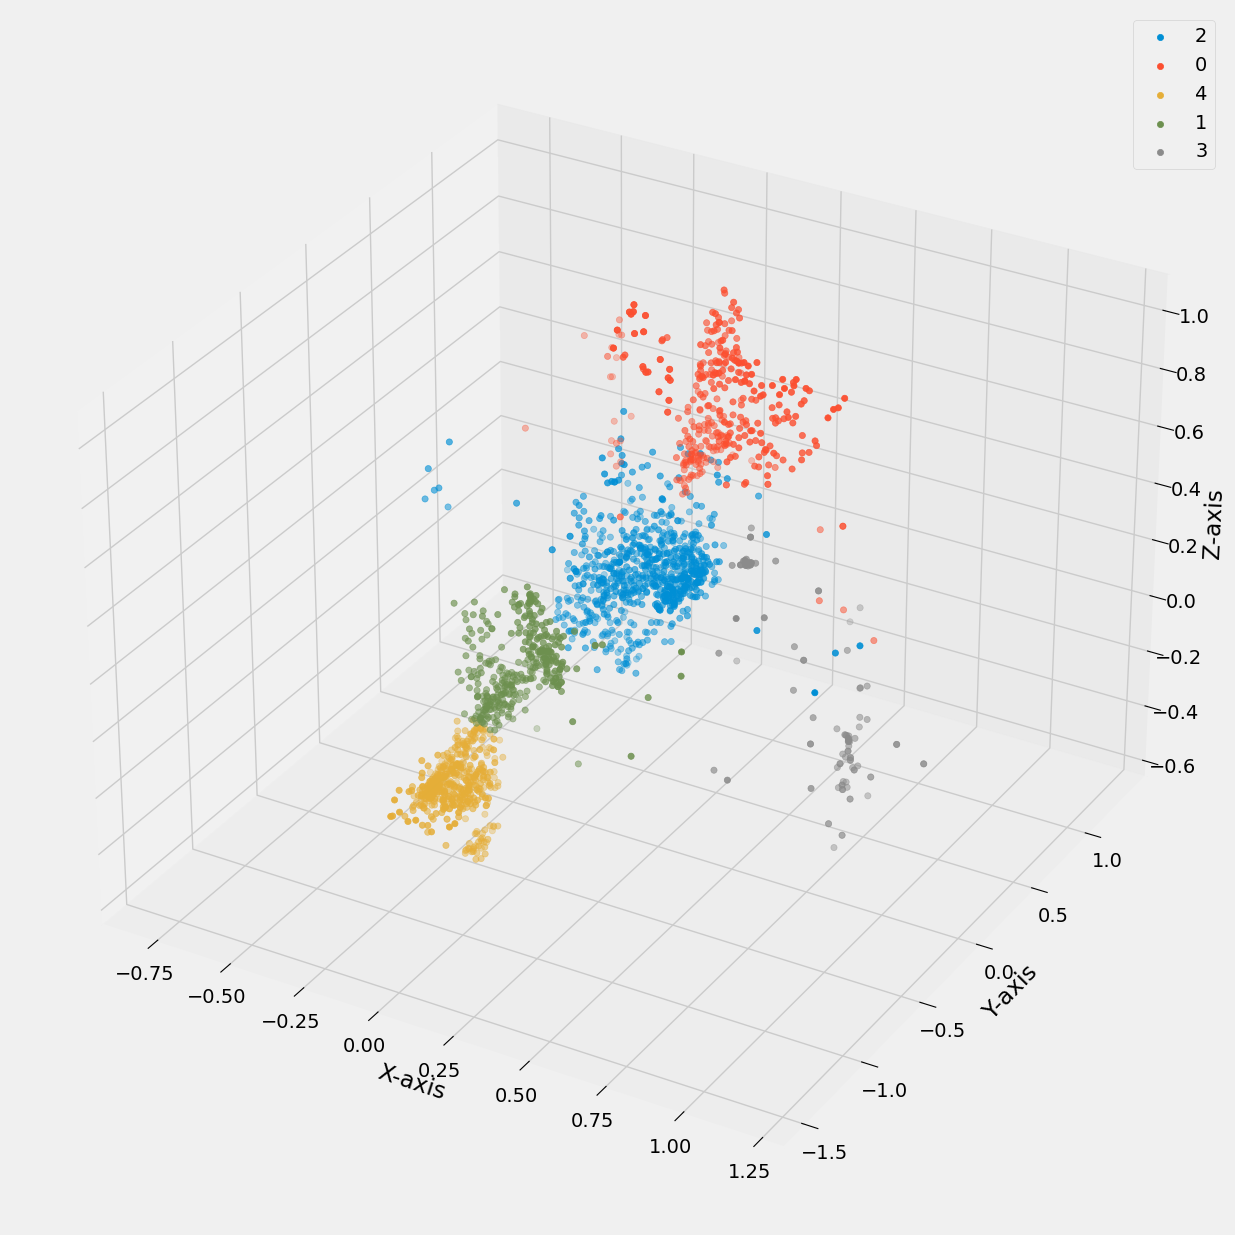

In [164]:
fig=plt.figure(figsize=(15,15))
ax=fig.add_subplot(projection='3d')

for c in df_cluster['cluster'].unique():
    subset=df_cluster[df_cluster['cluster']==c]
    ax.scatter(subset['acc_x'],subset['acc_y'],subset['acc_z'],label=c)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
plt.legend()
plt.show()
    

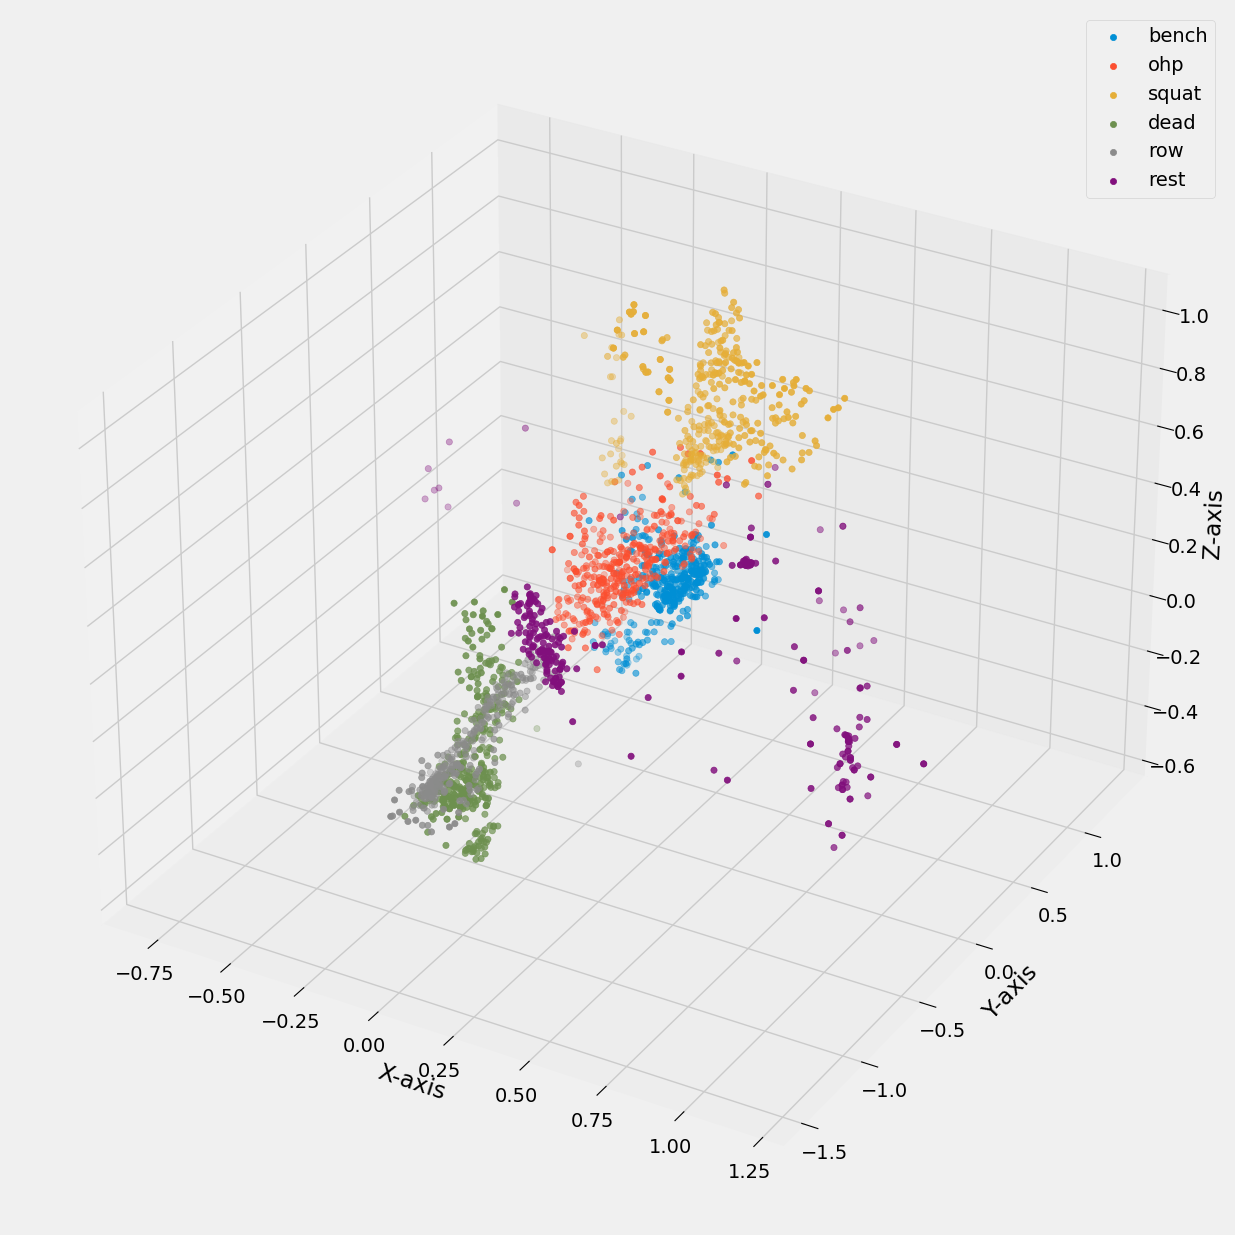

In [163]:
fig=plt.figure(figsize=(15,15))
ax=fig.add_subplot(projection='3d')

for l in df_cluster['label'].unique():
    subset=df_cluster[df_cluster['label']==l]
    ax.scatter(subset['acc_x'],subset['acc_y'],subset['acc_z'],label=l)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
plt.legend()
plt.show()
    

In [161]:
df_cluster['label'].unique()

array(['bench', 'ohp', 'squat', 'dead', 'row', 'rest'], dtype=object)

In [165]:
df_cluster.to_pickle('../../data/interim/03_data_features.pkl')